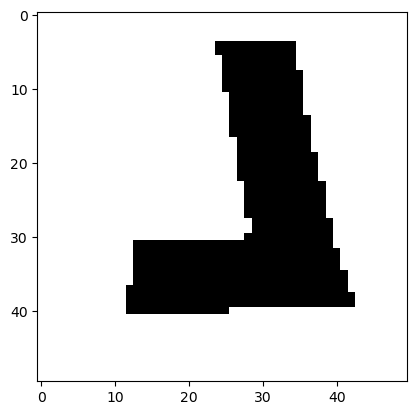

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import pmcx
from scipy.optimize import curve_fit
from cv2 import resize
import cv2
import os
from tqdm import tqdm
from scipy.signal import fftconvolve

#%% read and process obj image, note the obj image is capture from the galvo view
data_fold = r'F:\OneDrive\UK_projects_local\project in UK 2024\diffuse_experiment241021\zhiguan_data\XL_measurement_061224'
obj_img_path = os.path.join(data_fold, 'L_061224.bmp')
obj_img = plt.imread(obj_img_path)

#---------------get the obj ROI defined by the nine holes-----------
obj_img_10x10 = obj_img[360:720, 827:1188]
obj_img_10x10 = obj_img_10x10/obj_img_10x10.max()
obj_img_10x10[obj_img_10x10<0.5] = 0   # keep the obj as zero,in MCX a photon is terminated when moving from a non-zero to zero voxel.
obj_img_10x10[obj_img_10x10>=0.5] = 1

#---------------find the centre from the top, bottom and side of the image edges (10x10)cm----------
pix_ratio = np.round(np.mean([obj_img_10x10.shape[0], obj_img_10x10.shape[1]])/10)
from_top = np.round((1.75 + 2.5)*pix_ratio).astype('int') # center pixel to top edge in obj_img_10x10 measured in pixel scale
from_bot = np.round((10 - 1.75 - 2.5)*pix_ratio).astype('int') # center pixel to bottom edge in obj_img_10x10 measured in pixel scale
from_side = np.round(5*pix_ratio).astype('int') # center pixel to side edge in obj_img_10x10 measured in pixel scale
pix_4cm = np.round(4*pix_ratio).astype('int') # choose border 4cm from centre for a FOV=(8x8)cm
pix_2dot5cm = np.round(2.5*pix_ratio).astype('int') # choose border 4cm from centre for a FOV=(8x8)cm

#---------------crop required size--------------
obj_img_5x5 = obj_img_10x10[from_top - pix_2dot5cm:from_top + pix_2dot5cm,
                            from_side -pix_2dot5cm:from_side + pix_2dot5cm]

obj_img_8x8 = obj_img_10x10[from_top - pix_4cm:from_top + pix_4cm,
                            from_side -pix_4cm:from_side + pix_4cm]

obj_l_5x5cm_50x50_PMT_view = cv2.resize(np.fliplr(obj_img_5x5), (50, 50), interpolation=cv2.INTER_NEAREST)

plt.figure()
plt.imshow(obj_l_5x5cm_50x50_PMT_view, cmap='gray')
np.save("F:\OneDrive\MCX_foam_forward\MF_forward\obj_l_5x5cm_50x50_PMT_view.npy",obj_l_5x5cm_50x50_PMT_view)